In [1]:
import numpy as np
import matplotlib as mpl

import lightkurve as lk
import tessbkgd

In [2]:
%pylab inline --no-import-all
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
mpl.rcParams['font.size']=22              #10 
mpl.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

Populating the interactive namespace from numpy and matplotlib


In [3]:
target = "iot Dra"

In [4]:
search = lk.search_targetpixelfile(target)

In [5]:
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,165722603,0.0
1,TESS Sector 15,2019,TESS-SPOC,1800,165722603,0.0
2,TESS Sector 16,2019,SPOC,120,165722603,0.0
3,TESS Sector 16,2019,TESS-SPOC,1800,165722603,0.0
4,TESS Sector 22,2020,SPOC,120,165722603,0.0
5,TESS Sector 22,2020,TESS-SPOC,1800,165722603,0.0
6,TESS Sector 23,2020,SPOC,120,165722603,0.0
7,TESS Sector 23,2020,TESS-SPOC,1800,165722603,0.0
8,TESS Sector 24,2020,SPOC,120,165722603,0.0


In [6]:
tpf = search[0].download()

In [7]:
tpf.__class__ = tessbkgd.tessbkgd.bkgd_tpf

In [8]:
newbkgd,bkgdmask = tpf.get_bkgd()

/home/tim/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


/home/tim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  # Remove the CWD from sys.path while we load stuff.


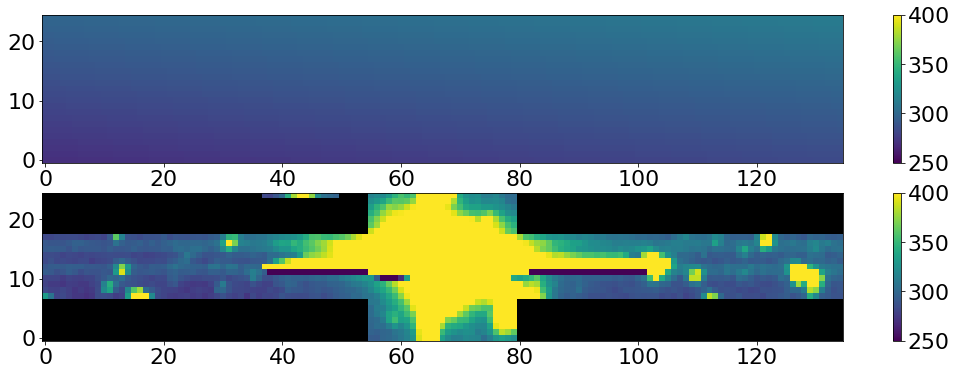

In [9]:
fig,axes = plt.subplots(2,1,figsize=(18,6))

xl=-0.5,134.5
asp = 1
frame = 8250
cmax = 400
cmin = 250

cmap = mpl.cm.viridis
cmap.set_bad('k',1.)
im = ((newbkgd[frame,:,:]).T)
img = axes[0].imshow(im,cmap=cmap, vmin=np.nanmin(cmin),vmax=np.nanmax(cmax),
    interpolation='None',origin='lower',aspect=asp)
plt.colorbar(img, ax=axes[0])

im2 = (((tpf.flux[frame,:,:]+tpf.flux_bkg[frame,:,:])).T)
img = axes[1].imshow(im2,cmap=cmap, vmin=np.nanmin(cmin),vmax=np.nanmax(cmax),
    interpolation='None',origin='lower',aspect=asp)
plt.colorbar(img, ax=axes[1])

plt.show()

In [10]:
if np.nansum(tpf.flux_bkg) == 0:  #No background previously set
    tpf.flux = tpf.flux - newbkgd
    tpf.flux_bkg = newbkgd
else:    #Need to add old background back in
    tpf.flux = tpf.flux + tpf.flux_bkg - newbkgd
    tpf.flux_bkg = newbkgd

In [11]:
from scipy.ndimage import binary_dilation

In [12]:
sapmask = tpf.create_threshold_mask(threshold=50)
sapmask = binary_dilation(sapmask,iterations=3)

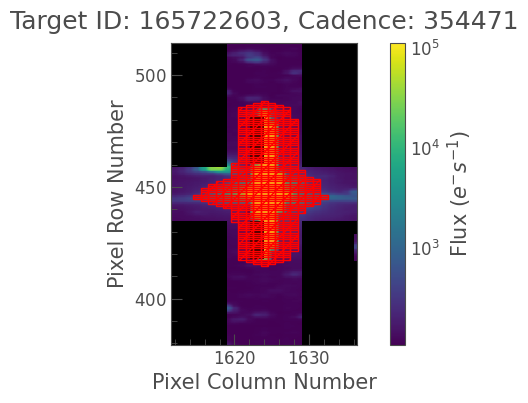

In [13]:
tpf.plot(aspect=0.3, scale='log', bkg = True, frame = 6000, aperture_mask = sapmask)
plt.show()

In [14]:
lc = tpf.extract_aperture_photometry(aperture_mask=sapmask)

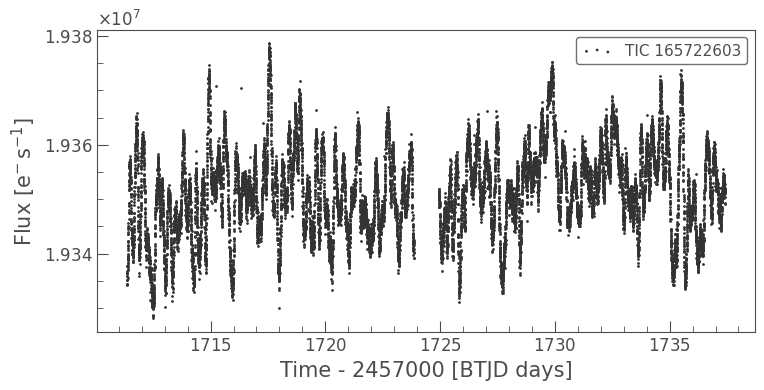

In [15]:
lc.scatter();

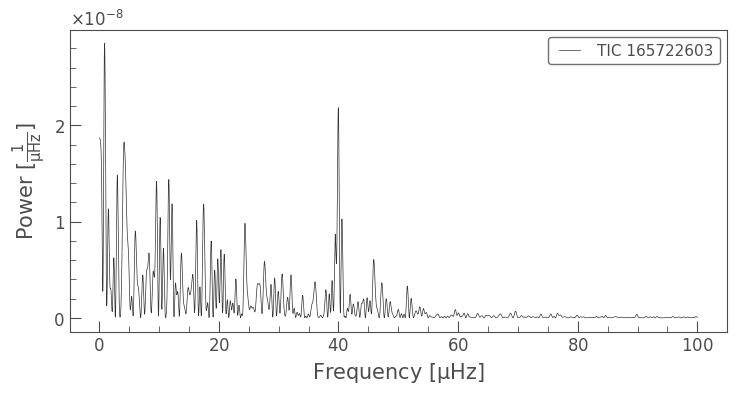

In [17]:
pg = lc.remove_nans().remove_outliers().normalize().to_periodogram(normalization='psd', oversample_factor=10, maximum_frequency = 100)
pg.plot(); 

In [18]:
tpf.to_fits(output_fn='iotDra_Sector15.fits')